In [1]:
# ===== 셀 1: 환경 설정 및 Import =====
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 프로젝트 경로 추가
import sys
sys.path.append('.')

# 모델 import
from models.backbones.convnext_fpn import ConvNeXtFPN
from models.heads.blade_head import SegFormerBladeHead
from models.heads.damage_head import DamageDetectionHead
from models.unified.unified_model import UnifiedModel
from models.unified.model_builder import ModelBuilder

# 데이터셋 import
from utils.dataset import UnifiedDamageDataset, create_dataloaders
from utils.evaluate import ModelEvaluator

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU: NVIDIA GeForce RTX 4090
GPU Memory: 25.76 GB


In [2]:
# ===== 셀 2: 설정 파라미터 =====
class Config:
    # 데이터 경로
    data_root = Path(r'C:\EngineBladeAI\EngineInspectionAI_MS\data\multilabeled_data_augmented')
    blade_checkpoint = 'best_unified_blade_model.pth'  # 기존 Head-A 체크포인트
    
    # 모델 설정
    backbone_type = 'tiny'
    use_fpn = True
    num_blade_classes = 2
    num_damage_classes = 3
    use_soft_gating = True
    boundary_margin = 10
    
    # 학습 설정
    batch_size = 4
    num_workers = 0
    epochs = 30
    learning_rate = 1e-4
    weight_decay = 0.01
    
    # 학습 전략
    freeze_blade_initially = True  # 처음엔 Head-A 고정
    unfreeze_epoch = 15  # 15 에폭 후 Head-A도 학습
    
    # Loss weights
    blade_loss_weight = 1.0
    damage_seg_loss_weight = 1.0
    damage_ml_loss_weight = 2.0
    
    # 기타
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_dir = Path('outputs')
    save_dir.mkdir(exist_ok=True)
    
    # 실험 이름
    experiment_name = f"unified_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

config = Config()
print(f"Experiment: {config.experiment_name}")

Experiment: unified_training_20250911_181223


In [3]:
# ===== 셀 3: 데이터로더 생성 =====
print("데이터로더 생성 중...")

train_loader, valid_loader, test_loader = create_dataloaders(
    data_root=config.data_root,
    batch_size=config.batch_size
)

print(f"✅ Train: {len(train_loader)} batches")
print(f"✅ Valid: {len(valid_loader)} batches")
print(f"✅ Test: {len(test_loader)} batches")

# 데이터 샘플 확인
for batch in train_loader:
    print(f"Batch keys: {batch.keys()}")
    print(f"Image shape: {batch['image'].shape}")
    print(f"Blade mask shape: {batch['blade_mask'].shape}")
    print(f"Damage mask shape: {batch['damage_mask'].shape}")
    print(f"Multilabel shape: {batch['multilabel'].shape}")
    break

데이터로더 생성 중...
Loaded train: 4704 images
Loaded valid: 906 images
Loaded test: 919 images
✅ Train: 1176 batches
✅ Valid: 227 batches
✅ Test: 230 batches
Batch keys: dict_keys(['image', 'blade_mask', 'damage_mask', 'multilabel', 'file_name'])
Image shape: torch.Size([4, 3, 640, 640])
Blade mask shape: torch.Size([4, 640, 640])
Damage mask shape: torch.Size([4, 640, 640])
Multilabel shape: torch.Size([4, 3])


In [4]:
# ===== 셀 4: 통합 모델 생성 =====
print("모델 생성 중...")

# ModelBuilder를 사용한 모델 생성
model_config = {
    'backbone': {
        'model_name': config.backbone_type,
        'use_fpn': config.use_fpn,
        'pretrained': True
    },
    'blade_head': {
        'in_channels': 256,
        'num_classes': config.num_blade_classes
    },
    'damage_head': {
        'in_channels': 256,
        'num_classes': config.num_damage_classes,
        'use_soft_gating': config.use_soft_gating,
        'boundary_margin': config.boundary_margin
    },
    'training': {
        'freeze_blade_head': config.freeze_blade_initially,
        'blade_checkpoint': config.blade_checkpoint if Path(config.blade_checkpoint).exists() else None
    }
}

model = ModelBuilder.build_unified_model(model_config)
model = model.to(config.device)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Total parameters: {total_params/1e6:.2f}M")
print(f"✅ Trainable parameters: {trainable_params/1e6:.2f}M")
print(f"✅ Blade head frozen: {config.freeze_blade_initially}")

모델 생성 중...
✅ Total parameters: 35.24M
✅ Trainable parameters: 34.71M
✅ Blade head frozen: True


In [5]:
# ===== 셀 5: Loss Functions 정의 =====
class UnifiedLoss(nn.Module):
    """통합 손실 함수"""
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Individual losses
        self.blade_ce = nn.CrossEntropyLoss()
        self.damage_ce = nn.CrossEntropyLoss(ignore_index=-1)
        self.damage_bce = nn.BCELoss()
        
    def dice_loss(self, pred, target):
        """Dice loss for segmentation"""
        pred = torch.softmax(pred, dim=1)[:, 1]  # blade class probability
        smooth = 1e-6
        
        intersection = (pred * target).sum(dim=(1, 2))
        union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2))
        dice = (2. * intersection + smooth) / (union + smooth)
        
        return 1 - dice.mean()
    
    def forward(self, outputs, batch):
        losses = {}
        
        # Blade segmentation loss
        if 'blade' in outputs:
            blade_loss = self.blade_ce(outputs['blade'], batch['blade_mask'])
            blade_dice = self.dice_loss(outputs['blade'], batch['blade_mask'].float())
            losses['blade'] = blade_loss + 0.5 * blade_dice
        
        # Damage segmentation loss
        if 'segmentation' in outputs:
            damage_mask = (batch['damage_mask'] > 0.5).long()
            damage_seg_loss = self.damage_ce(outputs['segmentation'], damage_mask)
            losses['damage_seg'] = damage_seg_loss
        
        # Damage multi-label loss
        if 'multilabel' in outputs:
            damage_ml_loss = self.damage_bce(outputs['multilabel'], batch['multilabel'])
            losses['damage_ml'] = damage_ml_loss
        
        # Total weighted loss
        total_loss = 0
        if 'blade' in losses:
            total_loss += self.config.blade_loss_weight * losses['blade']
        if 'damage_seg' in losses:
            total_loss += self.config.damage_seg_loss_weight * losses['damage_seg']
        if 'damage_ml' in losses:
            total_loss += self.config.damage_ml_loss_weight * losses['damage_ml']
        
        losses['total'] = total_loss
        
        return total_loss, losses

# Loss function 생성
criterion = UnifiedLoss(config)
print("✅ Loss functions ready")

✅ Loss functions ready


In [14]:
# ===== 셀 6: Optimizer & Scheduler (수정) =====
# Different learning rates for different parts
param_groups = [
    {'params': model.backbone.parameters(), 'lr': config.learning_rate * 0.1, 'name': 'backbone'},
    {'params': model.damage_head.parameters(), 'lr': config.learning_rate, 'name': 'damage_head'}
]

# Head-A는 frozen이 아닐 때만 추가
if not config.freeze_blade_initially:
    param_groups.append({'params': model.blade_head.parameters(), 'lr': config.learning_rate * 0.5, 'name': 'blade_head'})

optimizer = torch.optim.AdamW(param_groups, weight_decay=config.weight_decay)

# CosineAnnealingLR 사용 (OneCycleLR 대신)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.epochs,
    eta_min=1e-6
)

print("✅ Optimizer and Scheduler ready")
for group in param_groups:
    print(f"  {group['name']}: lr={group['lr']:.6f}")

✅ Optimizer and Scheduler ready
  backbone: lr=0.000010
  damage_head: lr=0.000100


In [15]:
# ===== 셀 7: Training Functions =====
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    """한 에폭 학습"""
    model.train()
    
    losses = {'total': 0, 'blade': 0, 'damage_seg': 0, 'damage_ml': 0}
    blade_ious = []
    damage_f1s = []
    
    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
        
        # Forward pass
        outputs = model(batch['image'])
        
        # Calculate loss
        loss, loss_dict = criterion(outputs, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Record losses
        for key in losses:
            if key in loss_dict:
                losses[key] += loss_dict[key].item()
        
        # Calculate metrics
        with torch.no_grad():
            # Blade IoU
            if 'blade' in outputs:
                blade_pred = outputs['blade'].argmax(1)
                intersection = (blade_pred & batch['blade_mask']).float().sum()
                union = (blade_pred | batch['blade_mask']).float().sum()
                iou = (intersection / (union + 1e-6)).item()
                blade_ious.append(iou)
            
            # Damage F1
            if 'multilabel' in outputs:
                pred_ml = (outputs['multilabel'] > 0.5).float()
                tp = (pred_ml * batch['multilabel']).sum(dim=0)
                fp = (pred_ml * (1 - batch['multilabel'])).sum(dim=0)
                fn = ((1 - pred_ml) * batch['multilabel']).sum(dim=0)
                
                f1 = 2 * tp / (2 * tp + fp + fn + 1e-6)
                damage_f1s.append(f1.mean().item())
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'blade_iou': f"{np.mean(blade_ious[-10:]):.3f}" if blade_ious else 0,
            'damage_f1': f"{np.mean(damage_f1s[-10:]):.3f}" if damage_f1s else 0,
            'lr': f"{scheduler.get_last_lr()[0]:.6f}"
        })
    
    # Average metrics
    avg_losses = {k: v / len(train_loader) for k, v in losses.items()}
    avg_blade_iou = np.mean(blade_ious) if blade_ious else 0
    avg_damage_f1 = np.mean(damage_f1s) if damage_f1s else 0
    
    return avg_losses, avg_blade_iou, avg_damage_f1


def validate_epoch(model, valid_loader, criterion, device):
    """검증"""
    model.eval()
    
    losses = {'total': 0, 'blade': 0, 'damage_seg': 0, 'damage_ml': 0}
    blade_ious = []
    damage_f1s = []
    
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc='Validation'):
            batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}
            
            outputs = model(batch['image'])
            loss, loss_dict = criterion(outputs, batch)
            
            for key in losses:
                if key in loss_dict:
                    losses[key] += loss_dict[key].item()
            
            # Metrics
            if 'blade' in outputs:
                blade_pred = outputs['blade'].argmax(1)
                intersection = (blade_pred & batch['blade_mask']).float().sum()
                union = (blade_pred | batch['blade_mask']).float().sum()
                blade_ious.append((intersection / (union + 1e-6)).item())
            
            if 'multilabel' in outputs:
                pred_ml = (outputs['multilabel'] > 0.5).float()
                tp = (pred_ml * batch['multilabel']).sum(dim=0)
                fp = (pred_ml * (1 - batch['multilabel'])).sum(dim=0)
                fn = ((1 - pred_ml) * batch['multilabel']).sum(dim=0)
                f1 = 2 * tp / (2 * tp + fp + fn + 1e-6)
                damage_f1s.append(f1.mean().item())
    
    avg_losses = {k: v / len(valid_loader) for k, v in losses.items()}
    avg_blade_iou = np.mean(blade_ious) if blade_ious else 0
    avg_damage_f1 = np.mean(damage_f1s) if damage_f1s else 0
    
    return avg_losses, avg_blade_iou, avg_damage_f1

In [16]:
# ===== 셀 8: Training Loop (CosineAnnealingLR로 변경) =====
print("=" * 60)
print("학습 시작")
print("=" * 60)

history = {
    'train_loss': [], 'val_loss': [],
    'train_blade_iou': [], 'val_blade_iou': [],
    'train_damage_f1': [], 'val_damage_f1': []
}

best_score = 0
best_epoch = 0

# CosineAnnealingLR로 변경 (더 안정적)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.epochs,
    eta_min=1e-6
)

for epoch in range(config.epochs):
    print(f"\nEpoch {epoch+1}/{config.epochs}")
    print("-" * 50)
    
    # Unfreeze blade head after certain epochs
    if epoch == config.unfreeze_epoch and config.freeze_blade_initially:
        print("🔓 Unfreezing Blade Head for fine-tuning")
        for param in model.blade_head.parameters():
            param.requires_grad = True
        
        # 파라미터 그룹 추가
        optimizer.add_param_group({
            'params': model.blade_head.parameters(),
            'lr': config.learning_rate * 0.1,
            'name': 'blade_head'
        })
        
        # CosineAnnealingLR은 그대로 사용 가능
        print("✅ Blade head added to optimizer")
    
    # Training
    train_losses, train_blade_iou, train_damage_f1 = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, config.device
    )
    
    # Validation  
    val_losses, val_blade_iou, val_damage_f1 = validate_epoch(
        model, valid_loader, criterion, config.device
    )
    
    # Record history
    history['train_loss'].append(train_losses['total'])
    history['val_loss'].append(val_losses['total'])
    history['train_blade_iou'].append(train_blade_iou)
    history['val_blade_iou'].append(val_blade_iou)
    history['train_damage_f1'].append(train_damage_f1)
    history['val_damage_f1'].append(val_damage_f1)
    
    # Combined score for model selection
    combined_score = 0.4 * val_blade_iou + 0.6 * val_damage_f1
    
    # Print epoch summary
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"  Train - Loss: {train_losses['total']:.4f}, Blade IoU: {train_blade_iou:.4f}, Damage F1: {train_damage_f1:.4f}")
    print(f"  Valid - Loss: {val_losses['total']:.4f}, Blade IoU: {val_blade_iou:.4f}, Damage F1: {val_damage_f1:.4f}")
    print(f"  Combined Score: {combined_score:.4f}")
    
    # Save best model
    if combined_score > best_score:
        best_score = combined_score
        best_epoch = epoch
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_score': best_score,
            'val_blade_iou': val_blade_iou,
            'val_damage_f1': val_damage_f1,
            'config': config.__dict__
        }
        
        save_path = config.save_dir / f'{config.experiment_name}_best.pth'
        torch.save(checkpoint, save_path)
        print(f"  ✅ Best model saved! (Score: {best_score:.4f})")

print("\n" + "=" * 60)
print(f"학습 완료! Best epoch: {best_epoch+1}, Best score: {best_score:.4f}")
print("=" * 60)

학습 시작

Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.27it/s]



📊 Epoch 1 Summary:
  Train - Loss: 0.4265, Blade IoU: 0.9973, Damage F1: 0.7790
  Valid - Loss: 1.2239, Blade IoU: 0.9984, Damage F1: 0.7056
  Combined Score: 0.8227
  ✅ Best model saved! (Score: 0.8227)

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 2 Summary:
  Train - Loss: 0.3831, Blade IoU: 0.9975, Damage F1: 0.7854
  Valid - Loss: 1.5430, Blade IoU: 0.9989, Damage F1: 0.6950
  Combined Score: 0.8165

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.27it/s]



📊 Epoch 3 Summary:
  Train - Loss: 0.3960, Blade IoU: 0.9969, Damage F1: 0.7711
  Valid - Loss: 1.4754, Blade IoU: 0.9985, Damage F1: 0.6991
  Combined Score: 0.8189

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.34it/s]



📊 Epoch 4 Summary:
  Train - Loss: 0.4117, Blade IoU: 0.9979, Damage F1: 0.7811
  Valid - Loss: 1.3463, Blade IoU: 0.9986, Damage F1: 0.6912
  Combined Score: 0.8142

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 5 Summary:
  Train - Loss: 0.3793, Blade IoU: 0.9959, Damage F1: 0.7864
  Valid - Loss: 1.3542, Blade IoU: 0.9987, Damage F1: 0.6843
  Combined Score: 0.8100

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.16it/s]



📊 Epoch 6 Summary:
  Train - Loss: 0.3554, Blade IoU: 0.9965, Damage F1: 0.7884
  Valid - Loss: 1.5880, Blade IoU: 0.9983, Damage F1: 0.6864
  Combined Score: 0.8111

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.16it/s]



📊 Epoch 7 Summary:
  Train - Loss: 0.3703, Blade IoU: 0.9982, Damage F1: 0.7804
  Valid - Loss: 2.2406, Blade IoU: 0.9988, Damage F1: 0.6791
  Combined Score: 0.8069

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 17.96it/s]



📊 Epoch 8 Summary:
  Train - Loss: 0.3518, Blade IoU: 0.9985, Damage F1: 0.7934
  Valid - Loss: 1.4961, Blade IoU: 0.9988, Damage F1: 0.6895
  Combined Score: 0.8132

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.21it/s]



📊 Epoch 9 Summary:
  Train - Loss: 0.3882, Blade IoU: 0.9977, Damage F1: 0.7858
  Valid - Loss: 1.6811, Blade IoU: 0.9988, Damage F1: 0.7003
  Combined Score: 0.8197

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.10it/s]



📊 Epoch 10 Summary:
  Train - Loss: 0.3505, Blade IoU: 0.9984, Damage F1: 0.7914
  Valid - Loss: 2.2629, Blade IoU: 0.9987, Damage F1: 0.7005
  Combined Score: 0.8198

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.28it/s]



📊 Epoch 11 Summary:
  Train - Loss: 0.3335, Blade IoU: 0.9984, Damage F1: 0.7814
  Valid - Loss: 1.9432, Blade IoU: 0.9986, Damage F1: 0.6877
  Combined Score: 0.8120

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.27it/s]



📊 Epoch 12 Summary:
  Train - Loss: 0.3338, Blade IoU: 0.9982, Damage F1: 0.7915
  Valid - Loss: 2.7716, Blade IoU: 0.9990, Damage F1: 0.7103
  Combined Score: 0.8258
  ✅ Best model saved! (Score: 0.8258)

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.20it/s]



📊 Epoch 13 Summary:
  Train - Loss: 0.3305, Blade IoU: 0.9977, Damage F1: 0.7990
  Valid - Loss: 2.2397, Blade IoU: 0.9990, Damage F1: 0.7046
  Combined Score: 0.8224

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 14 Summary:
  Train - Loss: 0.3158, Blade IoU: 0.9990, Damage F1: 0.7962
  Valid - Loss: 2.0396, Blade IoU: 0.9992, Damage F1: 0.6950
  Combined Score: 0.8167

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.18it/s]



📊 Epoch 15 Summary:
  Train - Loss: 0.3165, Blade IoU: 0.9985, Damage F1: 0.7888
  Valid - Loss: 3.9032, Blade IoU: 0.9988, Damage F1: 0.6954
  Combined Score: 0.8168

Epoch 16/30
--------------------------------------------------
🔓 Unfreezing Blade Head for fine-tuning
✅ Blade head added to optimizer


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 16 Summary:
  Train - Loss: 0.2833, Blade IoU: 0.9990, Damage F1: 0.7844
  Valid - Loss: 2.9820, Blade IoU: 0.9991, Damage F1: 0.6981
  Combined Score: 0.8185

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.07it/s]



📊 Epoch 17 Summary:
  Train - Loss: 0.2640, Blade IoU: 0.9992, Damage F1: 0.7953
  Valid - Loss: 4.4128, Blade IoU: 1.0000, Damage F1: 0.6757
  Combined Score: 0.8054

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 18 Summary:
  Train - Loss: 0.2521, Blade IoU: 0.9998, Damage F1: 0.7972
  Valid - Loss: 3.9981, Blade IoU: 1.0000, Damage F1: 0.6930
  Combined Score: 0.8158

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 19 Summary:
  Train - Loss: 0.2093, Blade IoU: 0.9999, Damage F1: 0.7961
  Valid - Loss: 2.7905, Blade IoU: 1.0000, Damage F1: 0.7065
  Combined Score: 0.8239

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 17.59it/s]



📊 Epoch 20 Summary:
  Train - Loss: 0.2033, Blade IoU: 0.9999, Damage F1: 0.7952
  Valid - Loss: 4.3374, Blade IoU: 1.0000, Damage F1: 0.6966
  Combined Score: 0.8179

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.02it/s]



📊 Epoch 21 Summary:
  Train - Loss: 0.1892, Blade IoU: 1.0000, Damage F1: 0.7934
  Valid - Loss: 3.5809, Blade IoU: 1.0000, Damage F1: 0.6549
  Combined Score: 0.7929

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.28it/s]



📊 Epoch 22 Summary:
  Train - Loss: 0.1808, Blade IoU: 1.0000, Damage F1: 0.7972
  Valid - Loss: 4.4327, Blade IoU: 1.0000, Damage F1: 0.6950
  Combined Score: 0.8170

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 23 Summary:
  Train - Loss: 0.1573, Blade IoU: 1.0000, Damage F1: 0.7911
  Valid - Loss: 6.8013, Blade IoU: 1.0000, Damage F1: 0.6793
  Combined Score: 0.8076

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.31it/s]



📊 Epoch 24 Summary:
  Train - Loss: 0.1532, Blade IoU: 1.0000, Damage F1: 0.8006
  Valid - Loss: 6.6778, Blade IoU: 1.0000, Damage F1: 0.6807
  Combined Score: 0.8084

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.32it/s]



📊 Epoch 25 Summary:
  Train - Loss: 0.1485, Blade IoU: 1.0000, Damage F1: 0.7986
  Valid - Loss: 6.6585, Blade IoU: 1.0000, Damage F1: 0.6846
  Combined Score: 0.8108

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.15it/s]



📊 Epoch 26 Summary:
  Train - Loss: 0.1211, Blade IoU: 1.0000, Damage F1: 0.7994
  Valid - Loss: 5.8414, Blade IoU: 1.0000, Damage F1: 0.6899
  Combined Score: 0.8140

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 17.75it/s]



📊 Epoch 27 Summary:
  Train - Loss: 0.1129, Blade IoU: 1.0000, Damage F1: 0.8024
  Valid - Loss: 6.2989, Blade IoU: 1.0000, Damage F1: 0.6957
  Combined Score: 0.8174

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.13it/s]



📊 Epoch 28 Summary:
  Train - Loss: 0.1401, Blade IoU: 1.0000, Damage F1: 0.7953
  Valid - Loss: 8.2995, Blade IoU: 1.0000, Damage F1: 0.6940
  Combined Score: 0.8164

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 17.57it/s]



📊 Epoch 29 Summary:
  Train - Loss: 0.0982, Blade IoU: 1.0000, Damage F1: 0.7958
  Valid - Loss: 6.9600, Blade IoU: 1.0000, Damage F1: 0.6881
  Combined Score: 0.8129

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 227/227 [00:12<00:00, 18.07it/s]


📊 Epoch 30 Summary:
  Train - Loss: 0.0755, Blade IoU: 1.0000, Damage F1: 0.7962
  Valid - Loss: 6.5921, Blade IoU: 1.0000, Damage F1: 0.6932
  Combined Score: 0.8159

학습 완료! Best epoch: 12, Best score: 0.8258


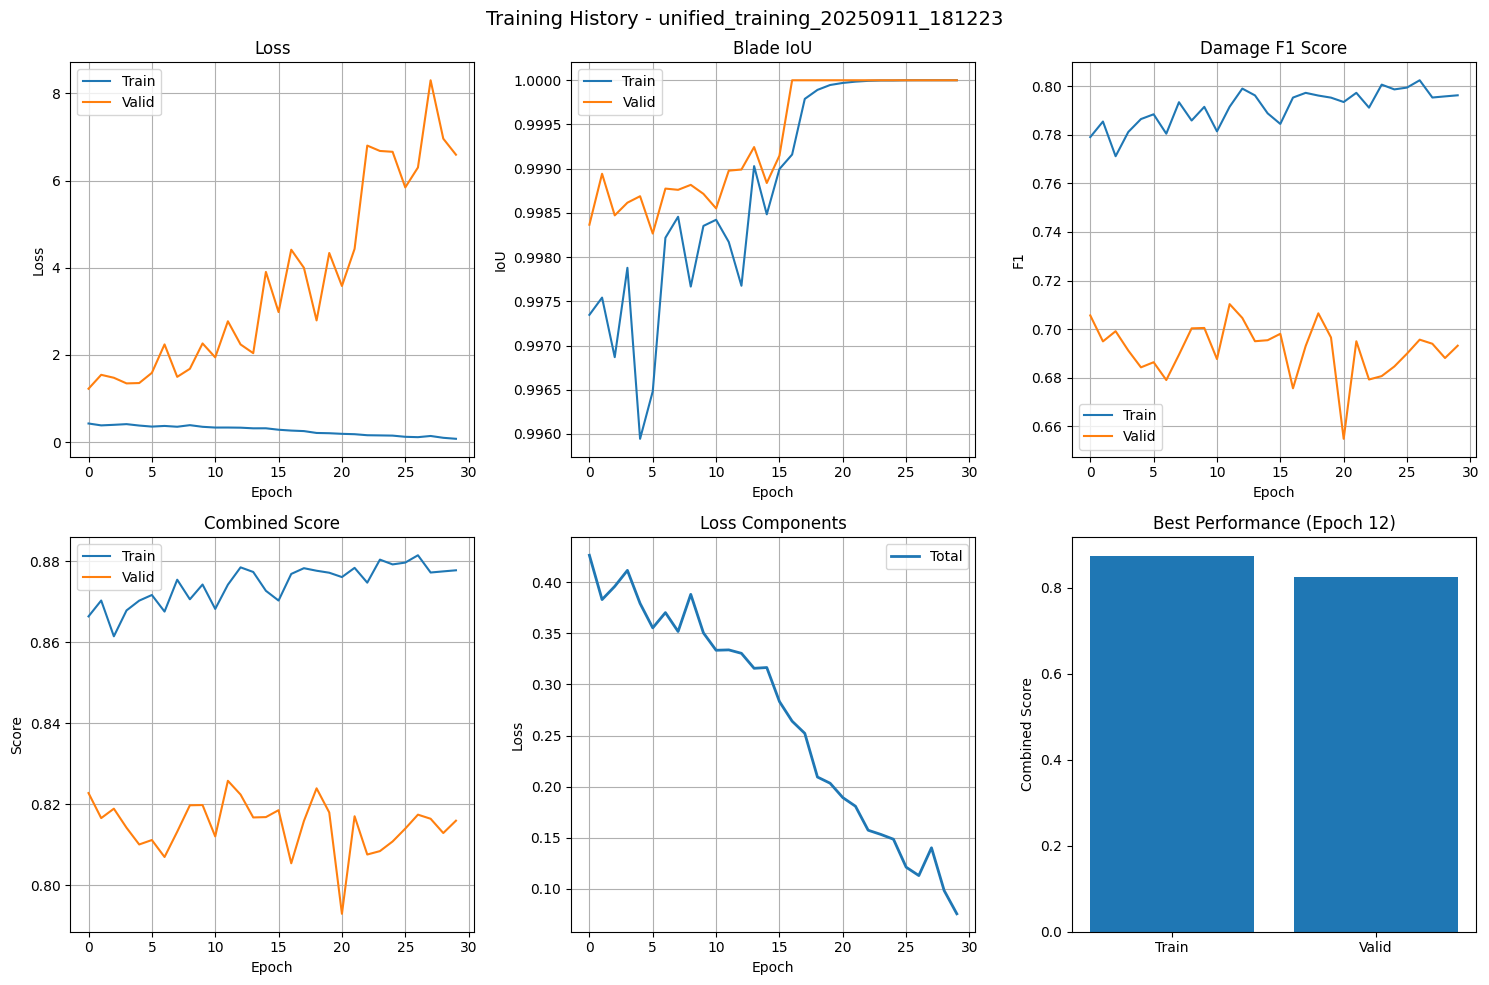

✅ Training history saved: outputs\unified_training_20250911_181223_history.png


In [17]:
# ===== 셀 9: 학습 곡선 시각화 =====
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train')
    axes[0, 0].plot(history['val_loss'], label='Valid')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Blade IoU
    axes[0, 1].plot(history['train_blade_iou'], label='Train')
    axes[0, 1].plot(history['val_blade_iou'], label='Valid')
    axes[0, 1].set_title('Blade IoU')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Damage F1
    axes[0, 2].plot(history['train_damage_f1'], label='Train')
    axes[0, 2].plot(history['val_damage_f1'], label='Valid')
    axes[0, 2].set_title('Damage F1 Score')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Combined metrics
    train_combined = [0.4 * iou + 0.6 * f1 for iou, f1 in 
                     zip(history['train_blade_iou'], history['train_damage_f1'])]
    val_combined = [0.4 * iou + 0.6 * f1 for iou, f1 in 
                   zip(history['val_blade_iou'], history['val_damage_f1'])]
    
    axes[1, 0].plot(train_combined, label='Train')
    axes[1, 0].plot(val_combined, label='Valid')
    axes[1, 0].set_title('Combined Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Loss components
    axes[1, 1].plot(history['train_loss'], label='Total', linewidth=2)
    axes[1, 1].set_title('Loss Components')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Best epoch marker
    best_epoch = np.argmax(val_combined)
    axes[1, 2].bar(['Train', 'Valid'], 
                   [train_combined[best_epoch], val_combined[best_epoch]])
    axes[1, 2].set_title(f'Best Performance (Epoch {best_epoch+1})')
    axes[1, 2].set_ylabel('Combined Score')
    
    plt.suptitle(f'Training History - {config.experiment_name}', fontsize=14)
    plt.tight_layout()
    
    save_path = config.save_dir / f'{config.experiment_name}_history.png'
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Training history saved: {save_path}")

plot_training_history(history)

In [18]:
# ===== 셀 10: 테스트셋 평가 =====
print("\n" + "=" * 60)
print("테스트셋 평가")
print("=" * 60)

# 최고 모델 로드
checkpoint_path = config.save_dir / f'{config.experiment_name}_best.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Loaded best model from epoch {checkpoint['epoch']+1}")

# 평가
evaluator = ModelEvaluator(model, config.device)
test_results = evaluator.evaluate(test_loader, verbose=True)

# 결과 저장
import json
results_path = config.save_dir / f'{config.experiment_name}_results.json'
with open(results_path, 'w') as f:
    json.dump({
        'config': config.__dict__,
        'best_epoch': checkpoint['epoch'],
        'test_results': {k: float(v) if isinstance(v, (np.float32, np.float64, torch.Tensor)) else v 
                        for k, v in test_results['overall_metrics'].items()}
    }, f, indent=2, default=str)

print(f"✅ Results saved: {results_path}")


테스트셋 평가
✅ Loaded best model from epoch 12


Evaluating Damage Detection: 100%|██████████| 230/230 [00:12<00:00, 17.99it/s]


EVALUATION RESULTS

📊 Blade Detection (Head-A):
  IoU:       0.9990
  Dice:      0.9995
  Precision: 1.0000
  Recall:    0.9990

📊 Damage Detection (Head-B):
  Average F1: 0.8725
  mAP:        0.8850
  Seg IoU:    0.2672
  Seg Dice:   0.3650

📊 Per-Class Damage Metrics:

  Crack:
    Precision: 0.7938
    Recall:    0.9663
    F1:        0.8716
    AP:        0.8223
    Support:   267

  Nick:
    Precision: 0.9214
    Recall:    0.9718
    F1:        0.9459
    AP:        0.9649
    Support:   567

  Tear:
    Precision: 0.7321
    Recall:    0.8818
    F1:        0.8000
    AP:        0.8678
    Support:   220

✅ Results saved: outputs\unified_training_20250911_181223_results.json


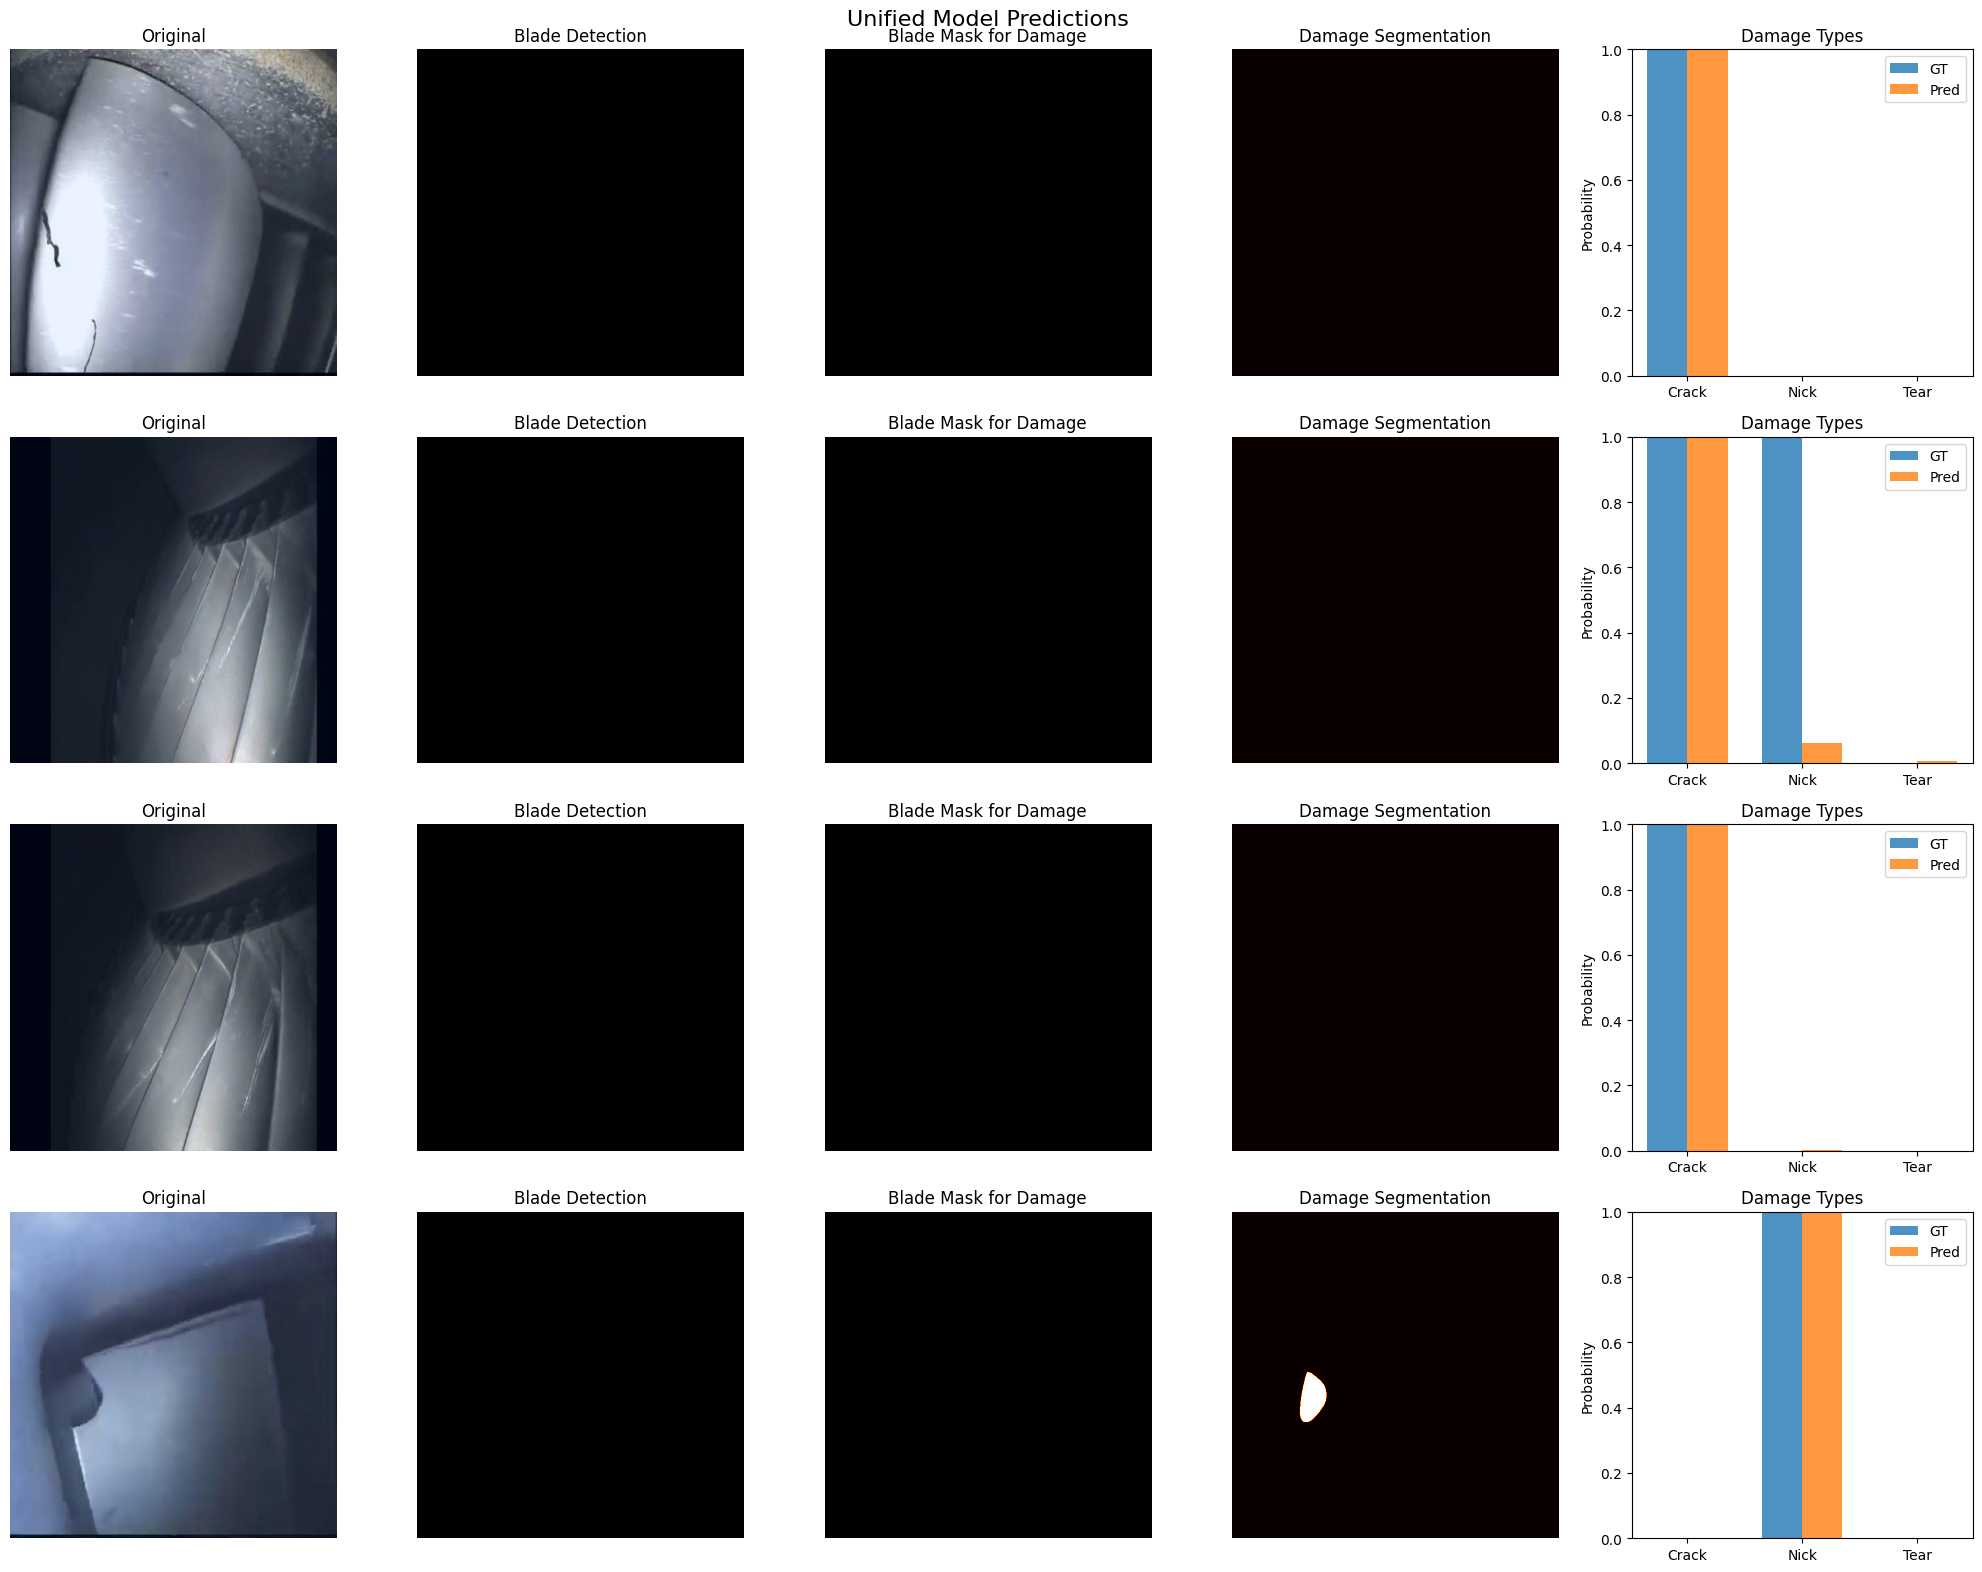

✅ Predictions saved: outputs\unified_training_20250911_181223_predictions.png


In [19]:
# ===== 셀 11: 예측 시각화 =====
def visualize_predictions(model, test_loader, num_samples=4):
    """통합 모델 예측 시각화"""
    model.eval()
    
    # 첫 번째 배치 가져오기
    for batch in test_loader:
        break
    
    batch = {k: v[:num_samples].to(config.device) if torch.is_tensor(v) else v[:num_samples] 
             for k, v in batch.items()}
    
    with torch.no_grad():
        outputs = model(batch['image'])
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    
    for i in range(num_samples):
        # 원본 이미지
        img = batch['image'][i].cpu()
        img = (img - img.min()) / (img.max() - img.min())
        img = img.permute(1, 2, 0)
        
        # 1. Original Image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        # 2. Blade Prediction
        blade_pred = outputs['blade'][i].argmax(0).cpu()
        axes[i, 1].imshow(blade_pred, cmap='gray')
        axes[i, 1].set_title('Blade Detection')
        axes[i, 1].axis('off')
        
        # 3. Blade Mask (generated)
        blade_mask = outputs['blade_mask'][i, 0].cpu()
        axes[i, 2].imshow(blade_mask, cmap='gray')
        axes[i, 2].set_title('Blade Mask for Damage')
        axes[i, 2].axis('off')
        
        # 4. Damage Segmentation
        damage_seg = outputs['segmentation'][i].argmax(0).cpu()
        axes[i, 3].imshow(damage_seg, cmap='hot')
        axes[i, 3].set_title('Damage Segmentation')
        axes[i, 3].axis('off')
        
        # 5. Multi-label Bar Chart
        ml_pred = outputs['multilabel'][i].cpu().numpy()
        ml_gt = batch['multilabel'][i].cpu().numpy()
        
        x = np.arange(3)
        width = 0.35
        axes[i, 4].bar(x - width/2, ml_gt, width, label='GT', alpha=0.8)
        axes[i, 4].bar(x + width/2, ml_pred, width, label='Pred', alpha=0.8)
        axes[i, 4].set_ylabel('Probability')
        axes[i, 4].set_title('Damage Types')
        axes[i, 4].set_xticks(x)
        axes[i, 4].set_xticklabels(['Crack', 'Nick', 'Tear'])
        axes[i, 4].legend()
        axes[i, 4].set_ylim([0, 1])
    
    plt.suptitle('Unified Model Predictions', fontsize=16)
    plt.tight_layout()
    
    save_path = config.save_dir / f'{config.experiment_name}_predictions.png'
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Predictions saved: {save_path}")

visualize_predictions(model, test_loader, num_samples=4)

In [20]:
# ===== 셀 12: 최종 요약 =====
print("\n" + "=" * 80)
print("🎉 통합 모델 학습 완료!")
print("=" * 80)

print(f"""
📊 최종 성능:
   Blade IoU: {test_results['blade_metrics']['iou']:.4f}
   Damage F1: {test_results['damage_metrics']['avg_f1']:.4f}
   Damage mAP: {test_results['damage_metrics']['mAP']:.4f}

📁 저장된 파일:
   Model: {config.save_dir / f'{config.experiment_name}_best.pth'}
   History: {config.save_dir / f'{config.experiment_name}_history.png'}
   Results: {config.save_dir / f'{config.experiment_name}_results.json'}
   
🔧 설정:
   Backbone: ConvNeXt-{config.backbone_type} with FPN
   Soft Gating: {config.use_soft_gating}
   Boundary Margin: {config.boundary_margin}px
   Two-stage Training: Epoch 1-{config.unfreeze_epoch} (Head-B only), 
                       Epoch {config.unfreeze_epoch+1}-{config.epochs} (Full model)
""")


🎉 통합 모델 학습 완료!

📊 최종 성능:
   Blade IoU: 0.9990
   Damage F1: 0.8725
   Damage mAP: 0.8850

📁 저장된 파일:
   Model: outputs\unified_training_20250911_181223_best.pth
   History: outputs\unified_training_20250911_181223_history.png
   Results: outputs\unified_training_20250911_181223_results.json

🔧 설정:
   Backbone: ConvNeXt-tiny with FPN
   Soft Gating: True
   Boundary Margin: 10px
   Two-stage Training: Epoch 1-15 (Head-B only), 
                       Epoch 16-30 (Full model)

